In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

import paragami
from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [65]:
#fitfile = './fits/transformed_gene_regression_df7_degree3_genes700_num_components30_fit.npz'
fitfile = './fits/transformed_gene_regression_df7_degree3_genes7000_num_components30_fit.npz'
with np.load(fitfile) as infile:
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    opt_gmm_params = gmm_params_pattern.fold(
        infile['opt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['prior_params_pattern_json']))
    prior_params = prior_params_pattern.fold(
        infile['prior_params_flat'], free=False)
    kl_hess = infile['kl_hess']
    df = infile['df']
    degree = infile['degree']
    datafile = str(infile['datafile'])
    num_components = int(infile['num_components'])

reg_params = dict()
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']


In [66]:
new_alpha = 20.0
prior_params['probs_alpha'][:] = new_alpha

gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

gmm.get_kl_conditioned.set_preconditioner_with_hessian(
    hessian=kl_hess, ev_min=1e-6)

init_x = gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True)

gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x, verbose=True)
opt_time = time.time() - tic
print('Re-optimization time: {} seconds'.format(opt_time))

Preconditioned iteration 1
  Running preconditioned optimization.
Iter 0: f = -482082.08822294
Iter 1: f = -482082.82925553
Iter 2: f = -482082.85429322
Iter 3: f = -482082.85430290
Iter 4: f = -482082.85430294
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Running preconditioned optimization.
Iter 5: f = -482082.85430294
Converged.
Re-optimization time: 177.5565733909607 seconds


0.005786578859613201

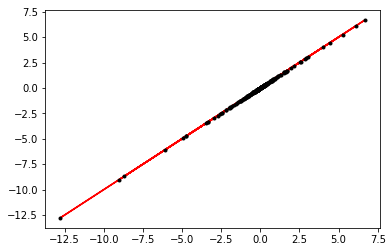

In [67]:
reopt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
def comparison_plot(x, y):
    plt.plot(x, x, 'r')
    plt.plot(x, y, 'k.')
    
comparison_plot(opt_gmm_params['centroids'], reopt_gmm_params['centroids'])
np.max(np.abs((opt_gmm_params['centroids'] - reopt_gmm_params['centroids'])))

0.06637761571077572

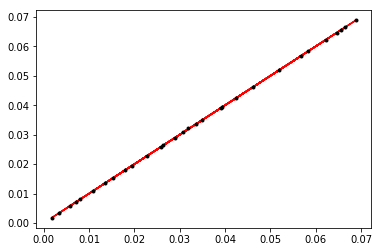

In [68]:
e_z0 = gmm.get_e_z(opt_gmm_params)
e_z1 = gmm.get_e_z(reopt_gmm_params)

comparison_plot(np.mean(e_z0, axis=0), np.mean(e_z1, axis=0))
np.max(np.abs(e_z0 - e_z1))

In [69]:
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_num_large_clusters_from_ez
n_samples = 1000
threshold = 5
unif_samples = np.random.random((gmm.num_obs, n_samples))

e_num0, var_num0 = get_e_num_large_clusters_from_ez(
    e_z0,
    threshold = threshold,
    n_samples = None,
    unif_samples = unif_samples)

e_num1, var_num1 = get_e_num_large_clusters_from_ez(
    e_z1,
    threshold = threshold,
    n_samples = None,
    unif_samples = unif_samples)

print(e_num1, e_num0, e_num1 - e_num0, np.std(var_num0), np.std(var_num1))

30.0 30.0 0.0 0.0 0.0
